### Random Forest and XGBoosting

This notebook explores two ensemble methods:

* bagging: random forest

* boosting: xgboosting

They are expected to achieve better performances than a single model such as decision tree!

There is a special parameter in Random Forest for balance weighting. It increases the weight for training samples that are rare, and hopefully could help deal with imbalanced dataset. The model performance using this parameter is compared to using SMOTE oversampling as a preprocessing step.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [ ]:
def cate_encoding(df, binary_vars):

  # change special values in some columns
  df['Diabetic'] =  df['Diabetic'].replace({'No, borderline diabetes':0,'Yes (during pregnancy)':1,'No':0,'Yes':1})
  df['Sex'] = df['Sex'].map({'Male':0,'Female':1})
  
  # encode binary variables
  for var in binary_vars:
    df[var] = df[var].map({'No':0,'Yes':1})

  # encode categorical variables having more than 2 levels

  # age is an ordinal variable, using one hot encoding results in too many variables
  age_values = sorted(df['AgeCategory'].unique())
  age_dict = {key: value for key, value in zip(age_values, list(range(13)))}  
  df['AgeCategory'] = df['AgeCategory'].map(age_dict)

  # dropping the original categorical features
  df.drop(columns = ['Race', 'GenHealth'], axis = 1, inplace = True)

  return df

In [ ]:
from google.colab import drive
import os 
drive.mount('/gdrive/')

Mounted at /gdrive/


In [ ]:
df = pd.read_csv('/gdrive/MyDrive/INDE577/heart.csv')
df = df[['HeartDisease','BMI','Smoking','AlcoholDrinking','PhysicalHealth','MentalHealth','Sex','AgeCategory','Diabetic','PhysicalActivity','SleepTime','Race', 'GenHealth']]
binary_vars = ['HeartDisease','Smoking','AlcoholDrinking','PhysicalActivity']
df = cate_encoding(df, binary_vars)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,PhysicalHealth,MentalHealth,Sex,AgeCategory,Diabetic,PhysicalActivity,SleepTime
0,0,16.60,1,0,3.0,30.0,1,7,1,1,5.0
1,0,20.34,0,0,0.0,0.0,1,12,0,1,7.0
2,0,26.58,1,0,20.0,30.0,0,9,1,1,8.0
3,0,24.21,0,0,0.0,0.0,1,11,0,0,6.0
4,0,23.71,0,0,28.0,0.0,1,4,0,1,8.0


In [ ]:
# HeartDisease: No: 292422; Yes:27373
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Random Forest

In [ ]:
# function to print evaluation metrics and visualizations
def plot_confusion(model, X_test, y_test):
  # predicted values on the testing data
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

  # print roc_auc
  roc_auc = roc_auc_score(y_test, model.predict(X_test))
  print('ROC-AUC is: ', roc_auc)

  # The confusion matrix
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

  # Convert confusion matrix into dataframe
  matrix_df = pd.DataFrame(confusion_matrix)


  plt.figure(figsize=(6,6))
  ax = plt.axes()
  sns.set(font_scale=1.3)

  sns.heatmap(matrix_df,
              annot = True, 
              fmt = "g",
              ax = ax, 
              cmap = "magma", 
              cbar = False)

  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Label", fontsize=15)
  ax.set_xticklabels(["No Heart Disease", "Heart Disease"])
  ax.set_ylabel("True Label", fontsize=15)
  ax.set_yticklabels(["No Heart Disease", "Heart Disease"], rotation=0)
  plt.show()

#### Without Balance Weighting

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     87730
           1       0.25      0.11      0.15      8209

    accuracy                           0.90     95939
   macro avg       0.58      0.54      0.55     95939
weighted avg       0.86      0.90      0.88     95939

ROC-AUC is:  0.5393043754594453


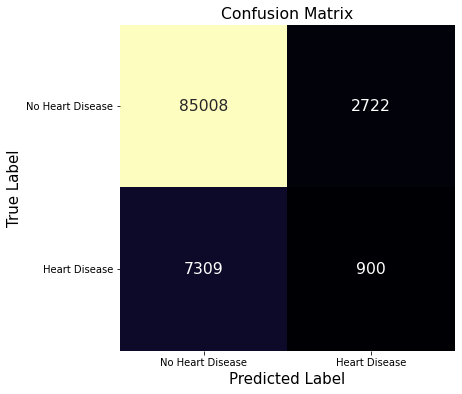

In [ ]:
rf = RandomForestClassifier(random_state = 42)
# Fit the random forest model
rf.fit(X_train, y_train)
plot_confusion(rf, X_test, y_test)

Without oversampling and balance weighting, the recall for positive samples is better than logistic regression and decision tree: it is 0.11 (default random forest) compared to 0.03/0.04 (decision tree and Logistic regression). It is inferior to those two models with oversampling, though.

Text(0, 0.5, 'Feature')

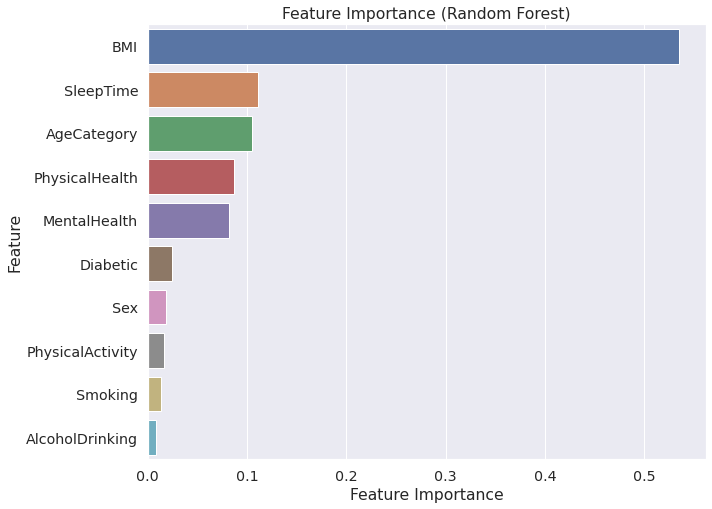

In [ ]:
imp_df = pd.DataFrame({'feature': X_train.columns, 'importance':list(rf.feature_importances_)})
imp_df.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(y='feature',x='importance', data = imp_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

It is also worth noting that feature importance ranking has a significant change: BMI is the most important feature and Age Category falls to the third. This may due to the 'randomness' included in Random Forest, each base model (tree) is using a different set of parameters to split the nodes, and the final result is aggregated based on base models' predictions.

#### Use Balance Weighting





              precision    recall  f1-score   support

           0       0.92      0.95      0.93     87730
           1       0.20      0.13      0.16      8209

    accuracy                           0.88     95939
   macro avg       0.56      0.54      0.55     95939
weighted avg       0.86      0.88      0.87     95939

ROC-AUC is:  0.5406899014916599


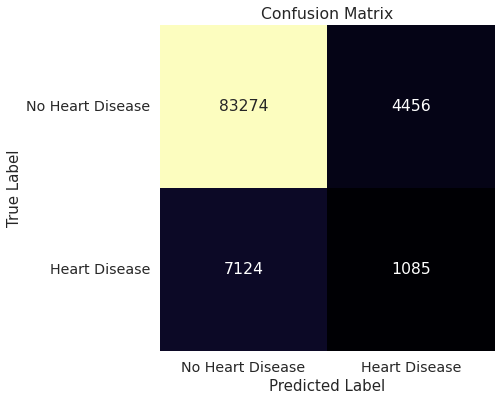

In [ ]:
rf_balanced = RandomForestClassifier(class_weight='balanced', random_state = 42)
# Fit the random forest model
rf_balanced.fit(X_train, y_train)
plot_confusion(rf_balanced, X_test, y_test)

We do not get a significant boost in recall for positive samples when setting the class_weight parameter to 'balanced'.

Text(0, 0.5, 'Feature')

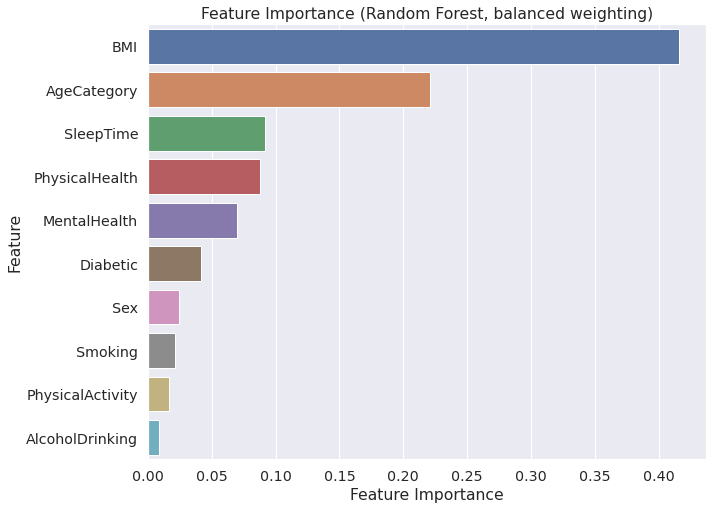

In [ ]:
imp_df = pd.DataFrame({'feature': X_train.columns, 'importance':list(rf_balanced.feature_importances_)})
imp_df.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(y='feature',x='importance', data = imp_df)
plt.title('Feature Importance (Random Forest, balanced weighting)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

Feature importance ranking changes again! But BMI is still the most important. Age Category's importance increases - this is maybe because the positive samples have higher weights, and we see a more similar feature importance ranking to our oversampled result.

#### Use SMOTE oversampling

In this section we directly use SMOTE oversampling before feeding the data into model.

In [ ]:
os_data_X = pd.read_csv('/content/SMOTE_training_x.csv')
os_data_y =  pd.read_csv('/content/SMOTE_training_y.csv')
X_test = pd.read_csv('/content/x_test.csv')
y_test = pd.read_csv('/content/y_test.csv')

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     87730
           1       0.20      0.29      0.23      8209

    accuracy                           0.84     95939
   macro avg       0.56      0.59      0.57     95939
weighted avg       0.87      0.84      0.85     95939

ROC-AUC is:  0.5877796715598115


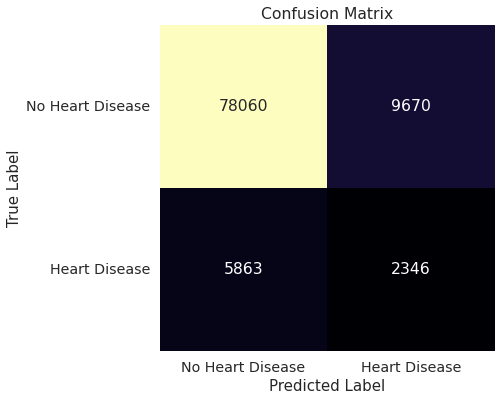

In [ ]:
rf_os = RandomForestClassifier(random_state = 42)
rf_os.fit(os_data_X, os_data_y)
# print precision, recall, plot confusion matrix
plot_confusion(rf_os, X_test, y_test)

#### Parameter Tuning

As we can see, the random forest model with default parameters using oversampling has lower roc-auc than a single decision tree. In this section we tried to improve random forest's performance by parameter tuning.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5,15, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, 
                               random_state=42, scoring = 'f1', n_jobs = -1)
# Fit the random search model
rf_random.fit(os_data_X, os_data_y)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15],
                                        'min_samples_leaf': [4, 8],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 300}

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     87730
           1       0.20      0.60      0.30      8209

    accuracy                           0.76     95939
   macro avg       0.58      0.69      0.58     95939
weighted avg       0.89      0.76      0.81     95939

ROC-AUC is:  0.6889289079883674


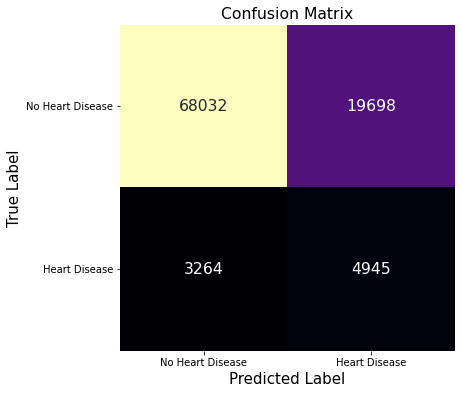

In [ ]:
rf_best = rf_random.best_estimator_
plot_confusion(rf_best, X_test, y_test)

Text(0, 0.5, 'Feature')

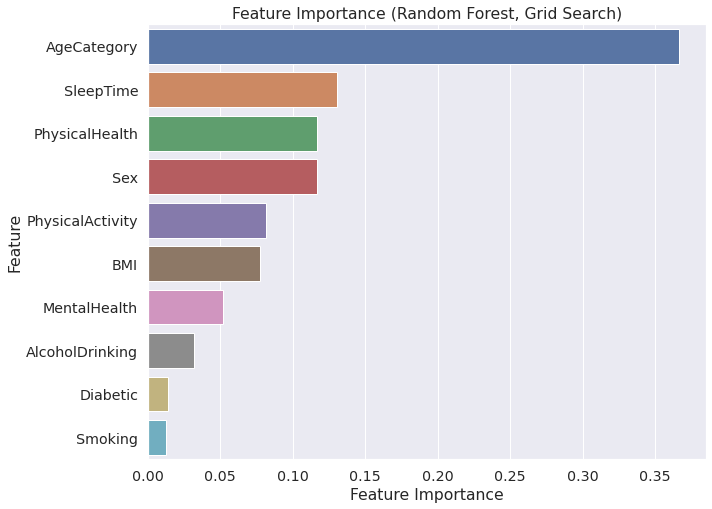

In [ ]:
imp_df = pd.DataFrame({'feature': os_data_X.columns, 'importance':list(rf_best.feature_importances_)})
imp_df.sort_values('importance', ascending = False, inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(y='feature',x='importance', data = imp_df)
plt.title('Feature Importance (Random Forest, Grid Search)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')

We can see that after parameter tuning (randomized search with cross validation) with scoring function of f1, we get better roc-auc than the random forest model with default parameters.

### XGboosting

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 30.1 MB/s 


In [ ]:
from xgboost.sklearn import XGBClassifier
import shap

In [ ]:
xgbclf = XGBClassifier(max_depth=8,
                      subsample=0.8,
                      objective='binary:logistic',
                      n_estimators=200,
                      learning_rate = 0.01)

eval_set = [(os_data_X, os_data_y), (X_test, y_test)]
# change verbose = False
xgbclf.fit(os_data_X, os_data_y, early_stopping_rounds=5, eval_metric=["error", "auc"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.238556	validation_0-auc:0.837057	validation_1-error:0.284952	validation_1-auc:0.778969
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-error:0.236905	validation_0-auc:0.839617	validation_1-error:0.281502	validation_1-auc:0.780585
[2]	validation_0-error:0.2369	validation_0-auc:0.841029	validation_1-error:0.281752	validation_1-auc:0.781351
[3]	validation_0-error:0.236538	validation_0-auc:0.841395	validation_1-error:0.280053	validation_1-auc:0.780857
[4]	validation_0-error:0.234638	validation_0-auc:0.842965	validation_1-error:0.282263	validation_1-auc:0.78185
[5]	validation_0-error:0.235825	validation_0-auc:0.843341	validation_1-error:0.284118	validation_1-auc:0.782162
[6]	validation_0-error:0.236003	validation_0-auc:0.843398	validation_1-error:0.285483	validation_1-auc:0.782156
[7]	validation_0-error:0.235876	validation_0-auc:0.843513	valid

XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8)

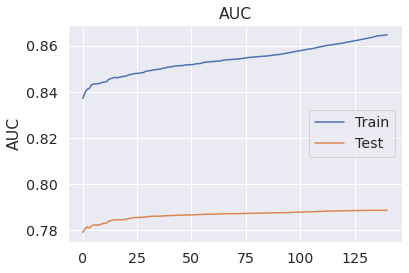

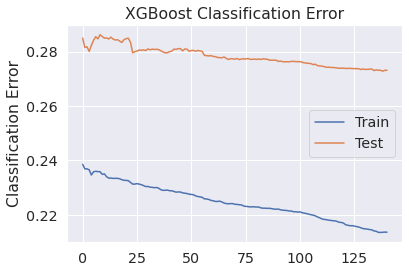

In [ ]:
# retrieve performance metrics
results = xgbclf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('AUC')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     87730
           1       0.19      0.70      0.30      8209

    accuracy                           0.73     95939
   macro avg       0.58      0.71      0.57     95939
weighted avg       0.90      0.73      0.79     95939

ROC-AUC is:  0.7131895788967126


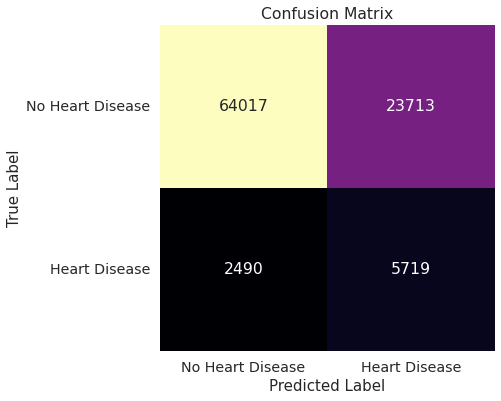

In [ ]:
# make predictions for test data
y_pred = xgbclf.predict(X_test)
y_proba = xgbclf.predict_proba(X_test)
plot_confusion(xgbclf,X_test,y_test)

From XGBoost we get by far the highest roc-auc score of 0.713.

SHAP (I tried to run SHAP for a better understanding of each feature's contribution, but it is too slow to fnish running)

In [ ]:
shap_values = shap.TreeExplainer(xgbclf).shap_values(os_data_X)
shap.summary_plot(shap_values, os_data_X)